## Run MD with vanilla/og system and then check that difference in energies between vanilla vs hybrid system are close to 0

In [1]:
from tqdm import tqdm_notebook
import openmmtools
import matplotlib.pyplot as plt
import pickle

from simtk import openmm
from simtk.openmm import unit
import openmmtools
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache
from openmmtools.constants import kB

from perses.annihilation.lambda_protocol import RESTState, RESTCapableRelativeAlchemicalState, RESTCapableLambdaProtocol
from perses.dispersed import feptasks

import numpy as np

from perses.app.relative_point_mutation_setup import PointMutationExecutor


INFO:rdkit:Enabling RDKit 2021.03.4 jupyter extensions


## Test at lambda = 0

In [3]:
# htf = solvent_delivery.get_apo_htf()
with open("/data/chodera/zhangi/perses_benchmark/repex/32/3/5/5_apo.pickle", "rb") as f:
    htf = pickle.load(f)
hybrid_system = htf.hybrid_system
hybrid_positions = htf.hybrid_positions
box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()


In [4]:
old_system = htf._topology_proposal.old_system
hybrid_system = htf.hybrid_system
for i in range(hybrid_system.getNumParticles()):
    if hybrid_system.getParticleMass(i) != old_system.getParticleMass(i):
        print(i, hybrid_system.getParticleMass(i), old_system.getParticleMass(i))

10 6.026000000000001 Da 3.0340000000000007 Da


OpenMMException: Assertion failure at System.cpp:55.  Index out of range

In [6]:
htf.hybrid_system.getForces()

[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b881e1e0c30> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b881e1e0b10> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b881e1e0cc0> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b881e1e0de0> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b881e1e0c00> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b887d432bd0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b887d4320f0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b887d432150> >]

In [7]:
T_min = 300 * unit.kelvin
T_max = 300 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
1.0
0.0


In [8]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [9]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [10]:
# Run MD
hybrid = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    hybrid.append(pos)


/scratch/lsftmp/4181369.tmpdir/ipykernel_23312/2861022740.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
# with open("hybrid_positions_atp.pickle", "wb") as f:
#     pickle.dump(hybrid, f)

In [11]:
# with open("hybrid_positions_atp.pickle", "rb") as f:
#     hybrid = pickle.load(f)

In [11]:
# Make context for og system
thermodynamic_state = ThermodynamicState(htf._topology_proposal.old_system, temperature=T_min)
integrator_og = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_og = thermodynamic_state.create_context(integrator_og)


# Zero the unique old/new valence in the hybrid system
bond_force_index = 1 
angle_force_index = 2 
torsion_force_index = 3 
custom_bond_force = hybrid_system.getForce(bond_force_index)
custom_angle_force = hybrid_system.getForce(angle_force_index)
custom_torsion_force = hybrid_system.getForce(torsion_force_index)
is_old = True
hybrid_to_bond_indices = htf._hybrid_to_new_bond_indices if is_old else htf._hybrid_to_old_bond_indices
hybrid_to_angle_indices = htf._hybrid_to_new_angle_indices if is_old else htf._hybrid_to_old_angle_indices
hybrid_to_torsion_indices = htf._hybrid_to_new_torsion_indices if is_old else htf._hybrid_to_old_torsion_indices
for hybrid_idx, idx in hybrid_to_bond_indices.items():
    p1, p2, hybrid_params = custom_bond_force.getBondParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-2] *= 0 # zero K_old
    hybrid_params[-1] *= 0 # zero K_new
    custom_bond_force.setBondParameters(hybrid_idx, p1, p2, hybrid_params)
for hybrid_idx, idx in hybrid_to_angle_indices.items():
    p1, p2, p3, hybrid_params = custom_angle_force.getAngleParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_angle_force.setAngleParameters(hybrid_idx, p1, p2, p3, hybrid_params)
for hybrid_idx, idx in hybrid_to_torsion_indices.items():
    p1, p2, p3, p4, hybrid_params = custom_torsion_force.getTorsionParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_torsion_force.setTorsionParameters(hybrid_idx, p1, p2, p3, p4, hybrid_params)

# Make context for hybrid system
T_min = 300 * unit.kelvin
T_max = 300 * unit.kelvin

lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

integrator_hybrid = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_hybrid = compound_thermodynamic_state.create_context(integrator_hybrid)

# Get energies for each conformation
energies_og = list()
energies_hybrid = list()
for pos in tqdm_notebook(hybrid):
   
    context_og.setPositions(htf.old_positions(pos))
    energy_og = context_og.getState(getEnergy=True).getPotentialEnergy()
    energies_og.append(energy_og.value_in_unit_system(unit.md_unit_system))
    
    context_hybrid.setPositions(pos)
    energy_hybrid = context_hybrid.getState(getEnergy=True).getPotentialEnergy()
    energies_hybrid.append(energy_hybrid.value_in_unit_system(unit.md_unit_system))
    
    print(energy_og, energy_hybrid)

/scratch/lsftmp/4181369.tmpdir/ipykernel_23312/400299692.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pos in tqdm_notebook(hybrid):


  0%|          | 0/500 [00:00<?, ?it/s]

-22693.075074555454 kJ/mol -22693.087428386738 kJ/mol
-21805.950074555454 kJ/mol -21805.962428386738 kJ/mol
-21345.332887055454 kJ/mol -21345.345240886738 kJ/mol
-20758.161012055454 kJ/mol -20758.169459636738 kJ/mol
-20620.926637055454 kJ/mol -20620.942897136738 kJ/mol
-20412.450074555454 kJ/mol -20412.470240886738 kJ/mol
-20517.746949555454 kJ/mol -20517.753444011738 kJ/mol
-20467.614137055454 kJ/mol -20467.630397136738 kJ/mol
-20447.746949555454 kJ/mol -20447.763209636738 kJ/mol
-20603.637574555454 kJ/mol -20603.657740886738 kJ/mol
-20231.621949555454 kJ/mol -20231.630397136738 kJ/mol
-20524.950074555454 kJ/mol -20524.962428386738 kJ/mol
-20415.645387055454 kJ/mol -20415.653834636738 kJ/mol
-20658.528199555454 kJ/mol -20658.546412761738 kJ/mol
-20491.731324555454 kJ/mol -20491.743678386738 kJ/mol
-20342.606324555454 kJ/mol -20342.618678386738 kJ/mol
-20544.731324555454 kJ/mol -20544.737819011738 kJ/mol
-20319.309449555454 kJ/mol -20319.321803386738 kJ/mol
-20347.942262055454 kJ/mol -

-20409.668824555454 kJ/mol -20409.677272136738 kJ/mol
-20074.926637055454 kJ/mol -20074.942897136738 kJ/mol
-20053.278199555454 kJ/mol -20053.298365886738 kJ/mol
-19916.028199555454 kJ/mol -19916.038600261738 kJ/mol
-20388.332887055454 kJ/mol -20388.341334636738 kJ/mol
-20293.129762055454 kJ/mol -20293.149928386738 kJ/mol
-20621.731324555454 kJ/mol -20621.747584636738 kJ/mol
-20085.661012055454 kJ/mol -20085.673365886738 kJ/mol
-20456.418824555454 kJ/mol -20456.427272136738 kJ/mol
-20425.114137055454 kJ/mol -20425.122584636738 kJ/mol
-20463.903199555454 kJ/mol -20463.923365886738 kJ/mol
-20600.450074555454 kJ/mol -20600.466334636738 kJ/mol
-20612.528199555454 kJ/mol -20612.540553386738 kJ/mol
-20136.325074555454 kJ/mol -20136.335475261738 kJ/mol
-20017.465699555454 kJ/mol -20017.480006511738 kJ/mol
-20110.996949555454 kJ/mol -20111.007350261738 kJ/mol
-20202.223512055454 kJ/mol -20202.239772136738 kJ/mol
-19883.434449555454 kJ/mol -19883.456569011738 kJ/mol
-19930.020387055454 kJ/mol -

-20042.223512055454 kJ/mol -20042.233912761738 kJ/mol
-20084.004762055454 kJ/mol -20084.017115886738 kJ/mol
-20585.559449555454 kJ/mol -20585.567897136738 kJ/mol
-20639.825074555454 kJ/mol -20639.841334636738 kJ/mol
-20433.840699555454 kJ/mol -20433.853053386738 kJ/mol
-20284.215699555454 kJ/mol -20284.235865886738 kJ/mol
-20480.950074555454 kJ/mol -20480.964381511738 kJ/mol
-20369.184449555454 kJ/mol -20369.200709636738 kJ/mol
-20382.246949555454 kJ/mol -20382.259303386738 kJ/mol
-20283.465699555454 kJ/mol -20283.481959636738 kJ/mol
-20305.715699555454 kJ/mol -20305.731959636738 kJ/mol
-20407.309449555454 kJ/mol -20407.325709636738 kJ/mol
-20499.918824555454 kJ/mol -20499.923365886738 kJ/mol
-20673.911012055454 kJ/mol -20673.927272136738 kJ/mol
-20347.106324555454 kJ/mol -20347.122584636738 kJ/mol
-20192.653199555454 kJ/mol -20192.673365886738 kJ/mol
-20395.090699555454 kJ/mol -20395.105006511738 kJ/mol
-20184.262574555454 kJ/mol -20184.274928386738 kJ/mol
-20457.567262055454 kJ/mol -

-20143.684449555454 kJ/mol -20143.700709636738 kJ/mol
-20284.371949555454 kJ/mol -20284.388209636738 kJ/mol
-20247.590699555454 kJ/mol -20247.595240886738 kJ/mol
-20288.121949555454 kJ/mol -20288.142115886738 kJ/mol
-20280.059449555454 kJ/mol -20280.071803386738 kJ/mol
-20324.512574555454 kJ/mol -20324.530787761738 kJ/mol
-19914.278199555454 kJ/mol -19914.290553386738 kJ/mol
-20159.012574555454 kJ/mol -20159.028834636738 kJ/mol
-20298.668824555454 kJ/mol -20298.685084636738 kJ/mol
-19924.981324555454 kJ/mol -19924.987819011738 kJ/mol
-20165.918824555454 kJ/mol -20165.925319011738 kJ/mol
-20446.621949555454 kJ/mol -20446.640162761738 kJ/mol
-20454.895387055454 kJ/mol -20454.907740886738 kJ/mol
-20491.543824555454 kJ/mol -20491.556178386738 kJ/mol
-20745.090699555454 kJ/mol -20745.099147136738 kJ/mol
-20550.653199555454 kJ/mol -20550.665553386738 kJ/mol
-20012.637574555454 kJ/mol -20012.649928386738 kJ/mol
-20201.950074555454 kJ/mol -20201.962428386738 kJ/mol
-20095.200074555454 kJ/mol -

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

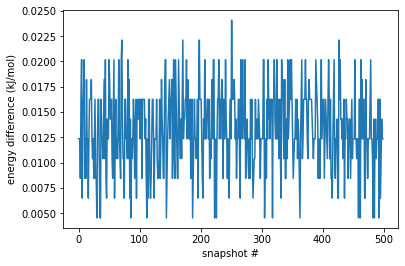

In [12]:
plt.plot(np.array(energies_og) - np.array(energies_hybrid))
plt.ylabel("energy difference (kJ/mol)")
plt.xlabel("snapshot #")
plt.show()

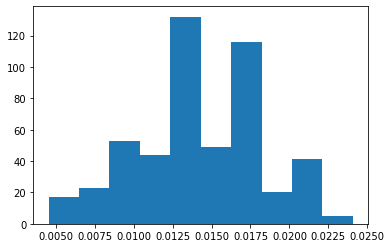

In [13]:
plt.hist(np.array(energies_og) - np.array(energies_hybrid))
plt.show()

In [15]:
# with open("energies_atp_hybrid.pickle", "wb") as f:
#     pickle.dump(energies_hybrid, f)
# with open("energies_atp_og.pickle", "wb") as f:
#     pickle.dump(energies_og, f)

## Test at lambda = 1

In [14]:
# htf = solvent_delivery.get_apo_htf()
with open("/data/chodera/zhangi/perses_benchmark/repex/32/3/5/5_apo.pickle", "rb") as f:
    htf = pickle.load(f)
hybrid_system = htf.hybrid_system
hybrid_positions = htf.hybrid_positions
box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()


In [15]:
htf.hybrid_system.getForces()

[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b887db2c210> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b887db2cea0> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b887dafa570> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b887dafa3f0> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b887dafa180> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b8877fea2a0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b887de04f60> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b887de04ed0> >]

In [20]:
T_min = 300 * unit.kelvin
T_max = 300 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
0.0
1.0


In [21]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [22]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [23]:
# Run MD
hybrid = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    hybrid.append(pos)


/scratch/lsftmp/4181369.tmpdir/ipykernel_23312/2861022740.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# with open("hybrid_positions_atp_lambda_1.pickle", "wb") as f:
#     pickle.dump(hybrid, f)

In [25]:
# with open("hybrid_positions_atp_lambda_1.pickle", "rb") as f:
#     hybrid = pickle.load(f)

In [24]:
# Make context for og system
thermodynamic_state = ThermodynamicState(htf._topology_proposal.new_system, temperature=T_min)
integrator_og = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_og = thermodynamic_state.create_context(integrator_og)


# Zero the unique old/new valence in the hybrid system
bond_force_index = 1 
angle_force_index = 2 
torsion_force_index = 3 
custom_bond_force = hybrid_system.getForce(bond_force_index)
custom_angle_force = hybrid_system.getForce(angle_force_index)
custom_torsion_force = hybrid_system.getForce(torsion_force_index)
is_old = False
hybrid_to_bond_indices = htf._hybrid_to_new_bond_indices if is_old else htf._hybrid_to_old_bond_indices
hybrid_to_angle_indices = htf._hybrid_to_new_angle_indices if is_old else htf._hybrid_to_old_angle_indices
hybrid_to_torsion_indices = htf._hybrid_to_new_torsion_indices if is_old else htf._hybrid_to_old_torsion_indices
for hybrid_idx, idx in hybrid_to_bond_indices.items():
    p1, p2, hybrid_params = custom_bond_force.getBondParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-2] *= 0 # zero K_old
    hybrid_params[-1] *= 0 # zero K_new
    custom_bond_force.setBondParameters(hybrid_idx, p1, p2, hybrid_params)
for hybrid_idx, idx in hybrid_to_angle_indices.items():
    p1, p2, p3, hybrid_params = custom_angle_force.getAngleParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_angle_force.setAngleParameters(hybrid_idx, p1, p2, p3, hybrid_params)
for hybrid_idx, idx in hybrid_to_torsion_indices.items():
    p1, p2, p3, p4, hybrid_params = custom_torsion_force.getTorsionParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_torsion_force.setTorsionParameters(hybrid_idx, p1, p2, p3, p4, hybrid_params)

# Make context for hybrid system
T_min = 300 * unit.kelvin
T_max = 300 * unit.kelvin

lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

integrator_hybrid = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_hybrid = compound_thermodynamic_state.create_context(integrator_hybrid)

# Get energies for each conformation
energies_og = list()
energies_hybrid = list()
for pos in tqdm_notebook(hybrid):
   
    context_og.setPositions(htf.new_positions(pos))
    energy_og = context_og.getState(getEnergy=True).getPotentialEnergy()
    energies_og.append(energy_og.value_in_unit_system(unit.md_unit_system))
    
    context_hybrid.setPositions(pos)
    energy_hybrid = context_hybrid.getState(getEnergy=True).getPotentialEnergy()
    energies_hybrid.append(energy_hybrid.value_in_unit_system(unit.md_unit_system))
    
    print(energy_og, energy_hybrid)

/scratch/lsftmp/4181369.tmpdir/ipykernel_23312/1827210720.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pos in tqdm_notebook(hybrid):


  0%|          | 0/500 [00:00<?, ?it/s]

-22750.58026267565 kJ/mol -22750.590862280827 kJ/mol
-21808.77557517565 kJ/mol -21808.786174780827 kJ/mol
-21256.05682517565 kJ/mol -21256.067424780827 kJ/mol
-21110.29901267565 kJ/mol -21110.313518530827 kJ/mol
-20681.32245017565 kJ/mol -20681.333049780827 kJ/mol
-20384.58807517565 kJ/mol -20384.602581030827 kJ/mol
-20170.81463767565 kJ/mol -20170.823284155827 kJ/mol
-20197.08807517565 kJ/mol -20197.106487280827 kJ/mol
-20554.45526267565 kJ/mol -20554.471721655827 kJ/mol
-20366.86932517565 kJ/mol -20366.887737280827 kJ/mol
-20361.27557517565 kJ/mol -20361.286174780827 kJ/mol
-20231.93182517565 kJ/mol -20231.938518530827 kJ/mol
-20301.61932517565 kJ/mol -20301.633831030827 kJ/mol
-20393.97088767565 kJ/mol -20393.983440405827 kJ/mol
-20290.33026267565 kJ/mol -20290.348674780827 kJ/mol
-20412.55682517565 kJ/mol -20412.571331030827 kJ/mol
-20307.75213767565 kJ/mol -20307.768596655827 kJ/mol
-20270.02557517565 kJ/mol -20270.040081030827 kJ/mol
-20328.76776267565 kJ/mol -20328.776409155827 

-20164.30682517565 kJ/mol -20164.317424780827 kJ/mol
-20357.13495017565 kJ/mol -20357.147502905827 kJ/mol
-20352.96307517565 kJ/mol -20352.983440405827 kJ/mol
-20711.61932517565 kJ/mol -20711.637737280827 kJ/mol
-20612.16620017565 kJ/mol -20612.172893530827 kJ/mol
-20447.01776267565 kJ/mol -20447.028362280827 kJ/mol
-20451.15057517565 kJ/mol -20451.157268530827 kJ/mol
-20480.07245017565 kJ/mol -20480.081096655827 kJ/mol
-20369.52557517565 kJ/mol -20369.540081030827 kJ/mol
-20185.68182517565 kJ/mol -20185.692424780827 kJ/mol
-20420.42401267565 kJ/mol -20420.438518530827 kJ/mol
-20437.30682517565 kJ/mol -20437.315471655827 kJ/mol
-20598.82245017565 kJ/mol -20598.831096655827 kJ/mol
-20319.43182517565 kJ/mol -20319.448284155827 kJ/mol
-20674.54120017565 kJ/mol -20674.559612280827 kJ/mol
-20335.18182517565 kJ/mol -20335.192424780827 kJ/mol
-20675.47870017565 kJ/mol -20675.485393530827 kJ/mol
-20575.65057517565 kJ/mol -20575.668987280827 kJ/mol
-20905.72870017565 kJ/mol -20905.735393530827 

-20717.00995017565 kJ/mol -20717.028362280827 kJ/mol
-20530.84588767565 kJ/mol -20530.862346655827 kJ/mol
-20491.94745017565 kJ/mol -20491.956096655827 kJ/mol
-20280.61151267565 kJ/mol -20280.626018530827 kJ/mol
-20242.19745017565 kJ/mol -20242.206096655827 kJ/mol
-20271.82245017565 kJ/mol -20271.833049780827 kJ/mol
-20261.28338767565 kJ/mol -20261.297893530827 kJ/mol
-20460.86932517565 kJ/mol -20460.879924780827 kJ/mol
-20340.72088767565 kJ/mol -20340.735393530827 kJ/mol
-20373.79120017565 kJ/mol -20373.809612280827 kJ/mol
-20441.61932517565 kJ/mol -20441.635784155827 kJ/mol
-20362.15838767565 kJ/mol -20362.172893530827 kJ/mol
-20535.51776267565 kJ/mol -20535.532268530827 kJ/mol
-20445.04901267565 kJ/mol -20445.061565405827 kJ/mol
-20422.58026267565 kJ/mol -20422.598674780827 kJ/mol
-20425.16620017565 kJ/mol -20425.180706030827 kJ/mol
-20553.21307517565 kJ/mol -20553.223674780827 kJ/mol
-20511.66620017565 kJ/mol -20511.680706030827 kJ/mol
-20395.97088767565 kJ/mol -20395.989299780827 

-20805.22870017565 kJ/mol -20805.235393530827 kJ/mol
-20565.75995017565 kJ/mol -20565.770549780827 kJ/mol
-20419.96307517565 kJ/mol -20419.977581030827 kJ/mol
-20299.66620017565 kJ/mol -20299.676799780827 kJ/mol
-20090.08807517565 kJ/mol -20090.104534155827 kJ/mol
-20168.47088767565 kJ/mol -20168.485393530827 kJ/mol
-20352.37713767565 kJ/mol -20352.387737280827 kJ/mol
-20006.95526267565 kJ/mol -20006.969768530827 kJ/mol
-20487.96307517565 kJ/mol -20487.967815405827 kJ/mol
-20411.57245017565 kJ/mol -20411.583049780827 kJ/mol
-20579.93963767565 kJ/mol -20579.954143530827 kJ/mol
-20255.15838767565 kJ/mol -20255.168987280827 kJ/mol
-20382.77557517565 kJ/mol -20382.784221655827 kJ/mol
-20602.80682517565 kJ/mol -20602.821331030827 kJ/mol
-20740.21307517565 kJ/mol -20740.219768530827 kJ/mol
-20564.78338767565 kJ/mol -20564.797893530827 kJ/mol
-20320.43182517565 kJ/mol -20320.446331030827 kJ/mol
-20325.11932517565 kJ/mol -20325.139690405827 kJ/mol
-20316.79901267565 kJ/mol -20316.813518530827 

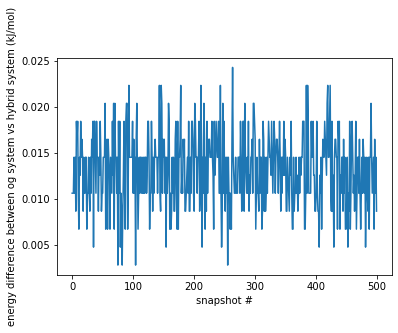

In [25]:
plt.plot(np.array(energies_og) - np.array(energies_hybrid))
plt.ylabel("energy difference between og system vs hybrid system (kJ/mol)")
plt.xlabel("snapshot #")
plt.show()

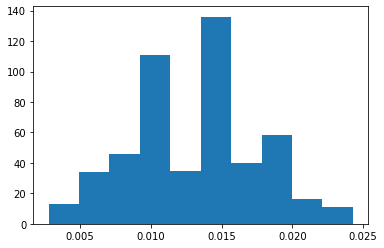

In [26]:
plt.hist(np.array(energies_og) - np.array(energies_hybrid))
plt.show()

In [34]:
# with open("energies_atp_hybrid_lambda_1.pickle", "wb") as f:
#     pickle.dump(energies_hybrid, f)
# with open("energies_atp_og_lambda_1.pickle", "wb") as f:
#     pickle.dump(energies_og, f)